In [1]:
from pandas_datareader import data as datareader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime

/anaconda2/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import r2_score, matthews_corrcoef, f1_score, mean_absolute_error
from sklearn.model_selection import train_test_split

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
np.random.seed(0)

# Data reading

In [5]:
from yahoofinancials import YahooFinancials

In [6]:
TICKER = 'DB'

In [7]:
aapl_yf = yahoo_financials_tech = YahooFinancials([TICKER])
data = aapl_yf.get_historical_price_data('2000-01-01', '2020-08-01', 'daily')

In [8]:
data = pd.DataFrame(data[TICKER]['prices'])
data = data.set_index('formatted_date')

In [9]:
data = data.dropna()

In [10]:
data

,date,high,low,open,close,volume,adjclose
formatted_date,,,,,,,
2000-01-03,946909800,82.061066,76.574425,77.767174,77.767174,32100,51.795048
2000-01-04,946996200,78.005722,76.335876,76.693703,76.693703,24900,51.080093
2000-01-05,947082600,80.391220,78.244278,78.602097,78.602097,21600,52.351143
2000-01-06,947169000,82.061066,80.391220,80.391220,80.391220,20100,53.542736
2000-01-07,947255400,83.969467,83.015266,83.969467,83.969467,27300,55.925941
...,...,...,...,...,...,...,...
2020-07-27,1595856600,9.570000,9.480000,9.530000,9.550000,1890800,9.550000
2020-07-28,1595943000,9.470000,9.320000,9.400000,9.450000,3287700,9.450000
2020-07-29,1596029400,9.250000,8.940000,8.980000,9.220000,11404400,9.220000


# Data Preparation

In [11]:
from mlfinlab.features.fracdiff import frac_diff_ffd
from utils import get_meta_barier, getDailyVol

In [12]:
data['close'].shape

(5178,)

In [13]:
try:
    frac_diff_series = frac_diff_ffd(pd.DataFrame(np.log(data['close'])), 0.7, thresh=1e-4)
except:
    print('Not calculated')
    frac_diff_series = pd.DataFrame(np.log(data['close'])).pct_change()

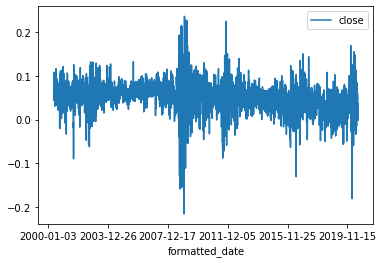

In [14]:
frac_diff_series.plot()

# Feature Extraction

In [15]:
from mlfinlab.microstructural_features import get_roll_measure, get_roll_impact
from mlfinlab.microstructural_features import get_corwin_schultz_estimator, get_bekker_parkinson_vol
from mlfinlab.microstructural_features import get_bar_based_kyle_lambda, get_bar_based_amihud_lambda, get_bar_based_hasbrouck_lambda

In [16]:
from ta import add_all_ta_features
from ta.utils import dropna

In [17]:
WINDOW = 14
INPUT_WINDOW = 3 # REDUCED THE CONTEXT
HORIZON = 1
N_SAMPLES = 25

In [18]:
def create_model():
    # added bagging of decison trees instead of linear models
    clf=RandomForestClassifier(n_estimators=1,
                               criterion='entropy',
                               bootstrap=False,
                               class_weight='balanced_subsample')
    clf=BaggingClassifier(base_estimator=clf,
                         n_estimators=100,
                         max_features=1.)
    return clf

# Feature Definition

In [19]:
# Add all ta features
technical_features = add_all_ta_features(
    data, open="open", high="high", low="low", close="close", volume="volume")

In [20]:
data['feat_new_volume_cmf'] = technical_features['volume_cmf']
data['feat_new_volatility_dcl'] = technical_features['volatility_dcl']
data['feat_new_trend_macd_diff'] = technical_features['trend_macd_diff']
data['feat_new_trend_vortex_ind_diff'] = technical_features['trend_vortex_ind_diff']
data['feat_new_momentum_stoch_signal'] = technical_features['momentum_stoch_signal']
data['feat_new_momentum_tsi'] = technical_features['momentum_tsi']

In [21]:
data['feat_new_roll_measure'] = get_roll_measure(data['close'], WINDOW)
data['feat_new_roll_impact'] = get_roll_impact(data['close'], data['volume'], WINDOW)
data['feat_new_corwin_schultz'] = get_corwin_schultz_estimator(data['high'], data['low'], WINDOW)
data['feat_new_bekker_parkinson_vol'] = get_bekker_parkinson_vol(data['high'], data['low'], WINDOW)
data['feat_new_kyle_lambda'] = get_bar_based_kyle_lambda(data['close'], data['volume'], WINDOW)
data['feat_new_amihud_lambda'] = get_bar_based_amihud_lambda(data['close'], data['volume'], WINDOW)
data['feat_new_hasbrouck_lambda'] = get_bar_based_hasbrouck_lambda(data['close'], data['volume'], WINDOW)

In [22]:
data['feat_new_min_frac_close'] = frac_diff_series.rolling(WINDOW).min()
data['feat_new_max_frac_close'] = frac_diff_series.rolling(WINDOW).max()
data['feat_new_mean_frac_close'] = frac_diff_series.rolling(WINDOW).mean()
data['feat_new_std_frac_close'] = frac_diff_series.rolling(WINDOW).std()
data['feat_new_skew_frac_close'] = frac_diff_series.rolling(WINDOW).skew()
data['feat_new_kurt_frac_close'] = frac_diff_series.rolling(WINDOW).kurt()
data['feat_new_autocorr_frac_close'] = frac_diff_series.rolling(WINDOW).apply(lambda x: x.autocorr(), raw=False)

In [23]:
FEATURE_COLUMNS = [d for d in data.columns if 'feat_new' in d]
dataset = data[FEATURE_COLUMNS]

In [24]:
dataset_normalized = {}
for feature_column in dataset.columns:
    feature_i = dataset[feature_column]
    feature_i_norm = (feature_i - feature_i.rolling(WINDOW).mean()) / feature_i.rolling(WINDOW).std()
    dataset_normalized[feature_column] = feature_i_norm
dataset_normalized = pd.DataFrame(
       dataset_normalized, index = dataset.index
)

In [25]:
dataset = dataset_normalized

In [26]:
dataset['close'] = data['close']
dataset = dataset.replace([np.inf, -np.inf], np.nan)
dataset = dataset.dropna()

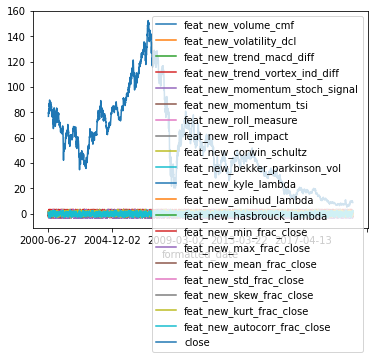

In [27]:
dataset.plot()

In [28]:
def createXY(inputs, outputs, training=False): 
    
    def flatten_features_window(x):
        mean = x.mean(axis=1)
        std = x.std(axis=1)
        low = x.min(axis=1)
        high = x.max(axis=1)
        open_f = x[:, 0]
        close_f = x[:, -1]
        return close_f
    
    X, Y, P = [], [], []
    
    # FIXED IID ASSUMPTION (up to some point)
    if training:
        SKIP = INPUT_WINDOW + HORIZON
    else:
        SKIP = 1
    
    for i in range(INPUT_WINDOW, len(inputs)-HORIZON, SKIP):

        window = inputs[i-INPUT_WINDOW:i].values
        future = (outputs[i+HORIZON] - outputs[i]) / outputs[i]
        future_binary = 1.0 if future > 0 else 0.0

        X.append(window)
        Y.append(future_binary)
        P.append(future)

    X, Y, P = np.array(X), np.array(Y), np.array(P)
    X = flatten_features_window(X)
    return X, Y, P

In [29]:
# training for longer time!
# dataset_train = dataset[:'2018']
# dataset_test = dataset['2019':]

# dataset_train = dataset['2000':'2001']
# dataset_test = dataset['2002':'2003']

dataset_train = dataset['2000':'2005']
dataset_test = dataset['2006':'2010']

In [30]:
# fixed train / test set 
X_train, Y_train, P_train = createXY(dataset_train[FEATURE_COLUMNS], dataset_train['close'], training=True)
X_test, Y_test, P_test = createXY(dataset_test[FEATURE_COLUMNS], dataset_test['close'])

In [31]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((254, 20), (254,), (954, 20), (954,))

# Modeling

In [32]:
mmcs, pred_prs = [], []
for n in range(N_SAMPLES):

    clf = create_model()

    clf.fit(X_train, Y_train)
    pred = clf.predict(X_test)
    pred_pr = clf.predict_proba(X_test)[:, 1]
    
    mmcs.append(matthews_corrcoef(Y_test, pred))
    pred_prs.append(pred_pr)

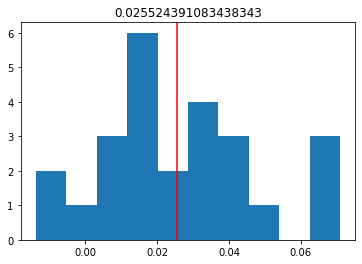

In [33]:
plt.figure()
plt.title(str(np.mean(mmcs)))
plt.hist(mmcs)
plt.axvline(np.mean(mmcs), color = 'red')
plt.show()

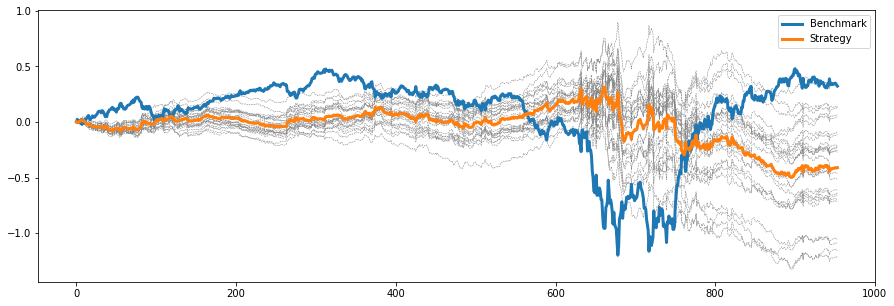

In [34]:
bagging_strategies, bagging_returns = [], []
plt.figure(figsize = (15, 5))

for pred_pr in pred_prs:
    signal = [-(1-p) if p <= 0.5 else p for p in pred_pr]
    bagging_strategies.append((signal * P_test).cumsum())
    bagging_returns.append(signal * P_test)
    plt.plot((signal * P_test).cumsum(), color = 'grey', ls = '--', lw=0.5)
    
plt.plot(P_test.cumsum(), lw = 3, label = 'Benchmark')
plt.plot(np.array(bagging_strategies).mean(axis=0), lw = 3, label = 'Strategy')

plt.legend()
plt.show()

In [35]:
benchmark_returns = P_test
strategy_returns = np.array(bagging_returns).mean(axis=0)

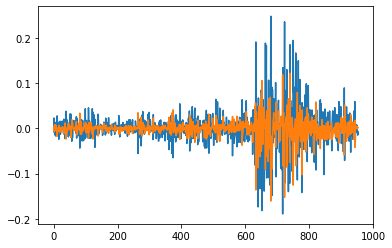

In [36]:
plt.figure()
plt.plot(benchmark_returns)
plt.plot(strategy_returns)
plt.show()

In [37]:
np.mean(benchmark_returns), np.mean(strategy_returns)

(0.0003388092269989405, -0.0004301582113059563)

# Evaluation

In [38]:
from mlfinlab.backtest_statistics import sharpe_ratio
from mlfinlab.backtest_statistics import probabilistic_sharpe_ratio
from mlfinlab.backtest_statistics import deflated_sharpe_ratio
from mlfinlab.backtest_statistics import information_ratio
from mlfinlab.backtest_statistics import minimum_track_record_length
from mlfinlab.backtest_statistics import drawdown_and_time_under_water

In [39]:
def ar1(x):
    return np.corrcoef(x[:-1], x[1:])[0,1]

def autocorr_penalty(x):
    n = len(x)
    p = np.abs(ar1(x))
    return np.sqrt(1 + 2*np.sum([((n - i)/n)*p**i for i in range(1,n)]))

def smart_sharpe(x):
    return (np.mean(x)/(np.std(x, ddof=1) * autocorr_penalty(x)) * np.sqrt(252))

In [40]:
benchmark_sharpe = sharpe_ratio(benchmark_returns, entries_per_year=252)
benchmark_sharpe_smart = smart_sharpe(benchmark_returns)
benchmark_sharpe, benchmark_sharpe_smart

(0.14104240930823447, 0.1313924767558224)

In [41]:
strategy_sharpe = sharpe_ratio(strategy_returns, entries_per_year=252)
strategy_sharpe_smart = smart_sharpe(strategy_returns)
strategy_sharpe, strategy_sharpe_smart

(-0.3299411492028417, -0.2991896479565386)

In [42]:
psr = probabilistic_sharpe_ratio(strategy_sharpe, benchmark_sharpe, len(benchmark_returns))
psr

8.175413480479119e-46

In [43]:
all_strategy_sharpes = []
for r in bagging_returns:
    sr_i = sharpe_ratio(r, entries_per_year=252)
    all_strategy_sharpes.append(sr_i)

dsr = deflated_sharpe_ratio(strategy_sharpe, all_strategy_sharpes, len(benchmark_returns))
dsr

5.922689116176199e-171

In [44]:
ir = information_ratio(strategy_returns, benchmark=np.mean(benchmark_returns), entries_per_year=252)
ir

-0.5898155460606217

In [45]:
mtrl = minimum_track_record_length(strategy_sharpe, benchmark_sharpe)
mtrl

13.860593560360934

# Checking Feature Importance

In [46]:
import shap
from sklearn.ensemble import RandomForestClassifier

In [47]:
# fixed train / test set 
X_train, Y_train, P_train = createXY(dataset_train[FEATURE_COLUMNS], dataset_train['close'], training=True)
X_test, Y_test, P_test = createXY(dataset_test[FEATURE_COLUMNS], dataset_test['close'])

In [48]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((254, 20), (254,), (954, 20), (954,))

In [49]:
X_train_df = pd.DataFrame(X_train, columns = FEATURE_COLUMNS)
X_test_df = pd.DataFrame(X_test, columns = FEATURE_COLUMNS)

In [50]:
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample', criterion='entropy')
clf.fit(X_train_df, Y_train)

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train_df)

fi0 = np.abs(shap_values[0]).mean(axis=0)
fi1 = np.abs(shap_values[1]).mean(axis=0)
fi = fi0 + fi1
imp = pd.DataFrame({
    'feature': X_train_df.columns.tolist(),
    'mean': fi
})
imp = imp.set_index('feature')

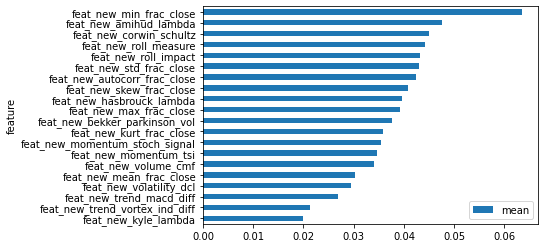

In [51]:
imp.sort_values('mean').plot.barh()

In [63]:
IMPORTANT_FEATURES = imp.sort_values('mean')[::-1][3:-3].index.values.tolist()
# IMPORTANT_FEATURES = imp[imp['mean'] > 0.0].index.values.tolist()
# IMPORTANT_FEATURES = FEATURE_COLUMNS

In [64]:
IMPORTANT_FEATURES

['feat_new_roll_measure',
 'feat_new_roll_impact',
 'feat_new_std_frac_close',
 'feat_new_autocorr_frac_close',
 'feat_new_skew_frac_close',
 'feat_new_hasbrouck_lambda',
 'feat_new_max_frac_close',
 'feat_new_bekker_parkinson_vol',
 'feat_new_kurt_frac_close',
 'feat_new_momentum_stoch_signal',
 'feat_new_momentum_tsi',
 'feat_new_volume_cmf',
 'feat_new_mean_frac_close',
 'feat_new_volatility_dcl']

# Retraining on the best features

In [65]:
X_train, Y_train, P_train = createXY(dataset_train[IMPORTANT_FEATURES], dataset_train['close'], training=True)
X_test, Y_test, P_test = createXY(dataset_test[IMPORTANT_FEATURES], dataset_test['close'])

In [66]:
mmcs, pred_prs = [], []
for n in range(N_SAMPLES):

    clf = create_model()

    clf.fit(X_train, Y_train)
    pred = clf.predict(X_test)
    pred_pr = clf.predict_proba(X_test)[:, 1]
    
    mmcs.append(matthews_corrcoef(Y_test, pred))
    pred_prs.append(pred_pr)

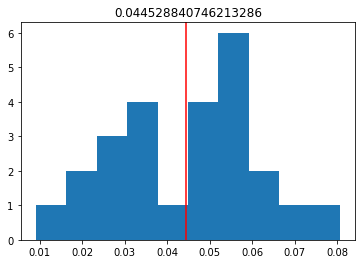

In [67]:
plt.figure()
plt.title(str(np.mean(mmcs)))
plt.hist(mmcs)
plt.axvline(np.mean(mmcs), color = 'red')
plt.show()

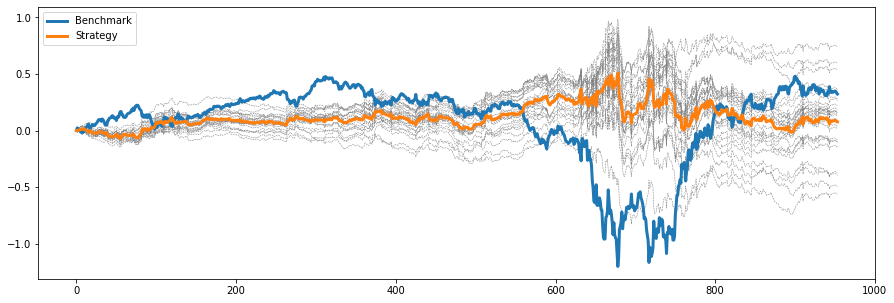

In [68]:
bagging_strategies, bagging_returns = [], []
plt.figure(figsize = (15, 5))

for pred_pr in pred_prs:
    signal = [-(1-p) if p <= 0.5 else p for p in pred_pr]
    bagging_strategies.append((signal * P_test).cumsum())
    bagging_returns.append(signal * P_test)
    plt.plot((signal * P_test).cumsum(), color = 'grey', ls = '--', lw=0.5)
    
plt.plot(P_test.cumsum(), lw = 3, label = 'Benchmark')
plt.plot(np.array(bagging_strategies).mean(axis=0), lw = 3, label = 'Strategy')

plt.legend()
plt.show()

In [69]:
strategy_returns_features = np.array(bagging_returns).mean(axis=0)

In [70]:
benchmark_sharpe = sharpe_ratio(benchmark_returns, entries_per_year=252)
benchmark_sharpe_smart = smart_sharpe(benchmark_returns)
benchmark_sharpe, benchmark_sharpe_smart

(0.14104240930823447, 0.1313924767558224)

In [71]:
strategy_sharpe = sharpe_ratio(strategy_returns, entries_per_year=252)
strategy_sharpe_smart = smart_sharpe(strategy_returns)
strategy_sharpe, strategy_sharpe_smart

(-0.3299411492028417, -0.2991896479565386)

In [72]:
strategy_sharpe_features = sharpe_ratio(strategy_returns_features, entries_per_year=252)
strategy_sharpe_features_smart = smart_sharpe(strategy_returns_features)
strategy_sharpe_features, strategy_sharpe_features_smart

(0.06162108584320511, 0.055604004456373486)

In [73]:
psr = probabilistic_sharpe_ratio(strategy_sharpe_features, strategy_sharpe, len(benchmark_returns))
psr

1.0